In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps

In [2]:
def get_rotmat_around_axis(angleRadian, axis):
    """
    Get a rotation matrix that rotate a vector
    with respect to an axis by some angle in radian.

    According to the right hand rule,
    if one aligns the thumb with the positive direction of the axis,
    then a positive angle is direction of your four fingers with
    a hollow fist.

    :param angleRadian:
    :param axis:
    :return:
    """

    # Check the axis length and normalize it
    if np.linalg.norm(axis) < 1e-6:
        print("The axis has to be a vector of unit length.")
        return False
    axis /= np.linalg.norm(axis)

    # Step 1: get a vector that is not parallel with the axis
    new_axis = np.zeros(3, dtype=np.float64)
    new_axis[0] = 1.0

    if np.linalg.norm(np.cross(new_axis, axis)) <= 1e-8:
        # If this relative is valid, then axis[0] ~ 1 while  axis[1] = axis[2] = 0
        new_axis[0] = 0.0
        new_axis[1] = 1.0

    # print(newAxis)

    # Step 2: remove the projection of the newAxis on the axis direction
    new_axis -= axis * np.dot(axis, new_axis)
    new_axis /= np.linalg.norm(new_axis)

    # print(newAxis)

    # Step 2: get the other vector though cross project
    new_axis2 = np.cross(axis, new_axis)

    # Construct the matrix
    rotMat = np.zeros((3, 3))
    rotMat += np.outer(axis, axis) + np.cos(angleRadian) * (np.outer(new_axis, new_axis) + np.outer(new_axis2, new_axis2))
    rotMat += np.sin(angleRadian) * (np.outer(new_axis2, new_axis) - np.outer(new_axis, new_axis2))

    return rotMat


In [10]:
Ec = 9.8  # keV
wavelength = 1.26514
kLen = np.pi * 2 / wavelength

# Get the rotation rotation matrix
angle_tmp = np.deg2rad(10)
rot_mat = get_rotmat_around_axis(angleRadian=np.deg2rad(3.49 * 2),
                                 axis=np.array([0, np.sin(angle_tmp), -np.cos(angle_tmp)]))

# Get the wavevector right in front of the mirror after the mirror 1 and the silicon 111
angle = np.deg2rad(2 * 11.639 - 0.2)
kVec = np.array([ 0, - np.sin(angle), np.cos(angle), ]) * kLen  # (x, y, z) in the xpp coordinate
kVec = np.dot(rot_mat, kVec)  # Add the rotation effect due to the mirror

# Get the reciprocal lattice of STO 220
gVec = np.array([1, 1, 0]) / np.sqrt(2) * np.pi * 2 / 1.3806

# Rotate the crystal to get a circle
angle_num = 20000 #// 50
angle_list = np.linspace(start= np.deg2rad(-1.5 - 2.5) , stop=np.deg2rad(-1.5 - 0.8), num=angle_num)
#angle_list = np.linspace(start= -np.deg2rad(45) , stop=np.deg2rad(90), num=angle_num)

tilt_angle = -np.deg2rad(11.5)
tilt_mat = np.array([[np.cos(tilt_angle), 0, -np.sin(tilt_angle)],
                     [0, 1, 0],
                     [np.sin(tilt_angle), 0, np.cos(tilt_angle)],])

gVec_list = np.zeros((angle_num, 3))
for idx in range(angle_num):
    angle_rot = angle_list[idx]
    rot_mat = np.array([[1, 0, 0],
                        [0, np.cos(angle_rot), -np.sin(angle_rot)],
                        [0, np.sin(angle_rot), np.cos(angle_rot)],])

    gVec_list[idx, :] = np.dot(tilt_mat, np.dot(rot_mat, gVec))
    
# Get the transient grating wavevector
tVec = np.array([1,0,0]) * kLen * np.sin(np.deg2rad(0.1567 * 2 - 7e-3)) * 2

In [11]:
kout = gVec_list + kVec[np.newaxis, :]
kout_len = np.linalg.norm(kout, axis=-1)
kout_len_diff = kout_len - kLen

kout_tg = gVec_list + kVec[np.newaxis, :] + tVec[np.newaxis, :]
kout_len_tg = np.linalg.norm(kout_tg, axis=-1)
kout_len_diff_tg = kout_len_tg - kLen

kout_tg1 = gVec_list + kVec[np.newaxis, :] - tVec[np.newaxis, :]
kout_len_tg1 = np.linalg.norm(kout_tg1, axis=-1)
kout_len_diff_tg1 = kout_len_tg1 - kLen

bragg_idx = np.argmin(np.abs(kout_len_diff))
tg_idx = np.argmin(np.abs(kout_len_diff_tg))
tg1_idx = np.argmin(np.abs(kout_len_diff_tg1))

bragg_angle = angle_list[bragg_idx]
bragg_angle_tg = angle_list[tg_idx]
bragg_angle_tg1 = angle_list[tg1_idx]

print("The Bragg angle is at {:.4f} deg".format(np.rad2deg(bragg_angle)))
#print(kout[np.argmin(np.abs(kout_len_diff))] / kout_tg[np.argmin(np.abs(kout_len_diff))][-1] * 115e3)

print("The Bragg angle with TG is at {:.4f} deg".format(np.rad2deg(bragg_angle_tg)))
print("The angular difference is {:.4f} deg".format(np.rad2deg(bragg_angle) - np.rad2deg(bragg_angle_tg)))
#print(kout_tg[np.argmin(np.abs(kout_len_diff_tg))] / kout_tg[np.argmin(np.abs(kout_len_diff_tg))][-1]* 115e3)

print("The Bragg angle with TG is at {:.4f} deg".format(np.rad2deg(bragg_angle_tg1)))
print("The angular difference is {:.4f} deg".format(np.rad2deg(bragg_angle) - np.rad2deg(bragg_angle_tg1)))
#print(kout_tg1[np.argmin(np.abs(kout_len_diff_tg1))] / kout_tg1[np.argmin(np.abs(kout_len_diff_tg1))][-1]* 115e3)

The Bragg angle is at -3.0555 deg
The Bragg angle with TG is at -3.7113 deg
The angular difference is 0.6558 deg
The Bragg angle with TG is at -2.4119 deg
The angular difference is -0.6437 deg


In [12]:
gVec_list[bragg_idx]

array([ 3.11927867,  3.21350625, -0.80967381])

In [13]:
kout_bragg = kout[bragg_idx]
kout_vec_tg = kout_tg[tg_idx]
kout_vec_tg1 = kout_tg1[tg1_idx]

In [14]:
np.linalg.norm(kout_vec_tg - kout_bragg)

0.05830442898854229

In [16]:
np.linalg.norm(kout_vec_tg1 - kout_bragg)

0.05799611368403418

In [119]:
pixel_res_A = 75e-6 / 13e-2 * np.pi * 2 / wavelength

In [122]:
print(pixel_res_A / np.pi / 2)
print(tVec / np.pi / 2)

0.0004560152053710079
[0.00845387 0.         0.        ]


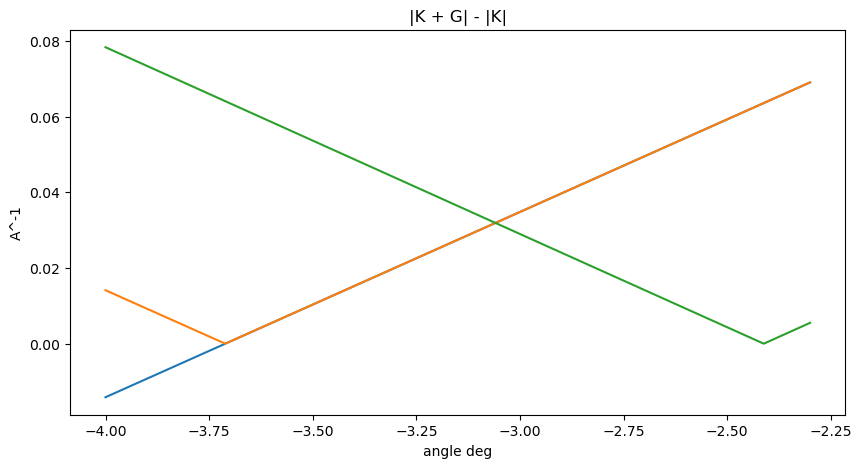

In [40]:
fig, ax = plt.subplots(ncols=1,nrows=1)
cmap = colormaps['summer']

fig.set_figheight(5)
fig.set_figwidth(10)

ax.plot(np.rad2deg(angle_list), kout_len_diff_tg)
ax.plot(np.rad2deg(angle_list), np.abs(kout_len_diff_tg))
ax.plot(np.rad2deg(angle_list), np.abs(kout_len_diff_tg1))

plt.title('|K + G| - |K|')
plt.ylabel("A^-1")
plt.xlabel('angle deg')
#plt.legend()
plt.show()